# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [3]:
USER_NAME = u"Кошман".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}w_j^{2} = \frac{1}{N}\sum_i \log(1 + e^{-y^{(i)} (\langle w, x^{(i)} \rangle + w_0) }) + \frac{1}{C}\sum_{j=1}^{m}w_j^{2}$$

$$ \frac{\partial L}{\partial w_0} = \frac{1}{N}\sum_i \frac{-y^{(i)}}{1 + e^{y^{(i)} (\langle w, x^{(i)} \rangle + w_0) )}}$$
$$ \frac{\partial L}{\partial w_j} = \frac{1}{N}\sum_i \frac{-y^{(i)}x^{(i)}_j}{1 + e^{y^{(i)} (\langle w, x^{(i)} \rangle + w_0) )}} + \frac{2}{C}w_i, i>0 $$

## Имплементация (5 баллов)

In [162]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=1., max_epoch=10, batch_size=50):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch 
        self.batch_size = batch_size
        self.losses = []
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        y = np.where(y, 1, -1)
        w = np.zeros(X.shape[1])
        x_args = np.arange(X.shape[0])
        n_batches = X.shape[0] / self.batch_size
        for epoch in range(self.max_epoch):
            np.random.shuffle(x_args)
            finish = True
            for batch in range(n_batches):
                X_batch = X[x_args[batch::n_batches]]
                y_batch = y[x_args[batch::n_batches]]
                multiplier = y_batch.reshape(-1, 1) * X_batch
                margin = np.dot(X_batch, w) * y_batch
                denominator = 1. + np.e ** margin
                dL_dw = (-1. / X_batch.shape[0]) * (multiplier.T / denominator).sum(axis=1)
                dL_dw += (2. / self.C) * np.concatenate(([0], w[1:]))
                if (dL_dw ** 2).sum() > 10 ** -4:
                    finish = False  
                w += -self.alpha * dL_dw / (epoch + 1)
            #print w
            self.losses.append(np.log(1. + np.e ** (-np.dot(X, w) * y)).sum() / X.shape[0] + \
                               (1. / self.C) * (w[1:] ** 2).sum())
            if finish:
                print 'finish', epoch
                break
                
        self.w = w
        self.dL_dw = dL_dw
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        ready_x = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        return np.where(np.dot(ready_x, self.w) > 0, 1, 0)
    
    @staticmethod
    def sigmoid(x):
        return 1. / (1 + np.e ** (-x))
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        ready_x = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        
        return self.sigmoid(np.dot(ready_x, self.w))

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [188]:
np.random.seed(0)

C1 = np.array([[0.0, -0.8], [1.5, 0.8]])
C2 = np.array([[1.0, -0.7], [2.0, 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

best = 0.8825, 0.895

0.8875
[-2.73987379  0.71222332 -0.59681403]


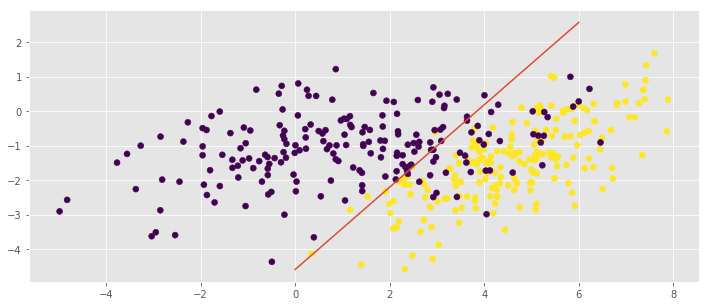

In [208]:
msgd = MySGDClassifier(max_epoch=100, C=100.0, alpha=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y)
msgd.fit(X, y)
# space = np.linspace(X[:, 0].min(), X[:, 0].max())
space = np.linspace(0, 6)
space_y = -(msgd.w[0] + msgd.w[1] * space) / msgd.w[2]
plt.plot(space, space_y)
print(float((msgd.predict(X) == y).sum()) / y.shape[0])
print(msgd.w)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [26]:
from sklearn.datasets import make_classification

In [27]:
X, y = make_classification(
    n_samples=100000,
    n_features=10,
    n_informative=4,
    n_redundant=0,
    random_state=123,
    class_sep=1.0,
    n_clusters_per_class=1,
)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

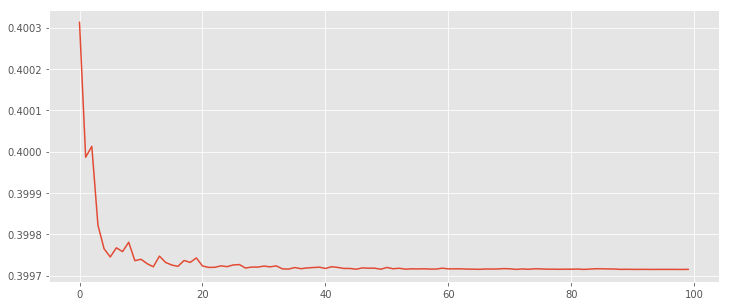

In [78]:
model = MySGDClassifier(C=5.0, max_epoch=100, alpha=0.1)
model.fit(X, y)
(model.predict(X) == y).sum(), y.shape
plt.plot(model.losses)

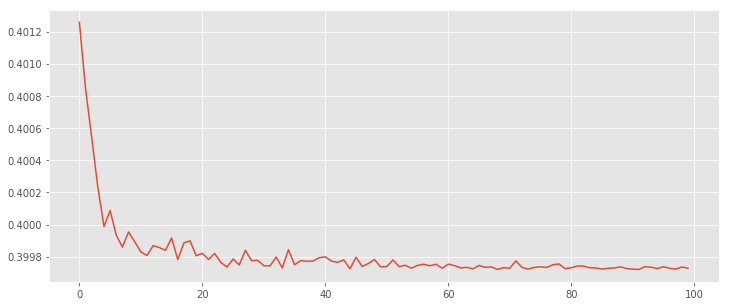

In [79]:
model = MySGDClassifier(C=5.0, max_epoch=100, alpha=0.5)
model.fit(X, y)
(model.predict(X) == y).sum(), y.shape
plt.plot(model.losses)

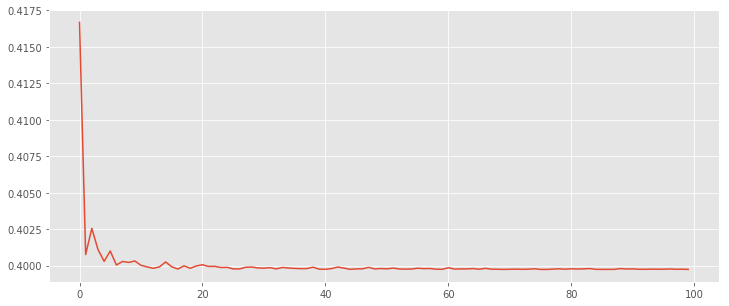

In [80]:
model = MySGDClassifier(C=5.0, max_epoch=100, alpha=1.0)
model.fit(X, y)
(model.predict(X) == y).sum(), y.shape
plt.plot(model.losses)

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

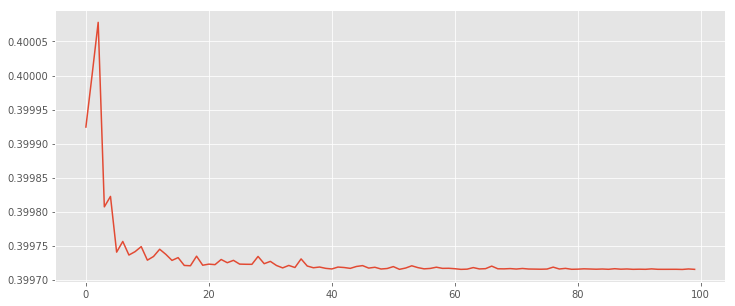

In [81]:
model = MySGDClassifier(C=5.0, max_epoch=100, alpha=0.1)
model.fit(X, y)
(model.predict(X) == y).sum(), y.shape
plt.plot(model.losses)

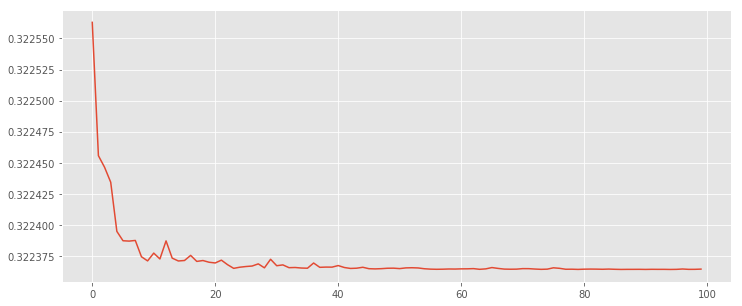

In [82]:
model = MySGDClassifier(C=10.0, max_epoch=100, alpha=0.1)
model.fit(X, y)
(model.predict(X) == y).sum(), y.shape
plt.plot(model.losses)

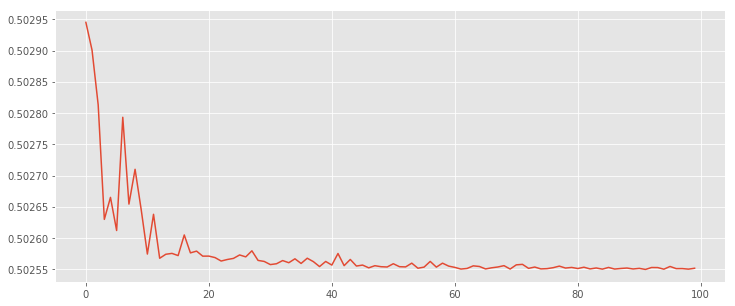

In [83]:
model = MySGDClassifier(C=2.0, max_epoch=100, alpha=0.1)
model.fit(X, y)
(model.predict(X) == y).sum(), y.shape
plt.plot(model.losses)

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [ ]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [93]:
# Загрузка одной части данных
filepath = "C:/Users/Dima/Downloads/lin_model_hw/lin_model_hw/trainingData_tabular/trainingData_tabular_chunk3.csv"
df_data = pd.read_csv(filepath, sep=",")

In [94]:
df_data.shape

(500000, 45)

In [95]:
# для удобства
df_data.columns = df_data.columns.str.replace(".", "_")
df_data = df_data.set_index("gamestate_id")

In [96]:
df_data.head().T

gamestate_id,4398318.0,4515958.0,2618902.0,4635943.0,2596956.0
decision,1,0,0,0,1
turn,3,17,13,5,16
opponent_armor,0,0,0,0,0
opponent_attack,3,0,0,0,3
opponent_hero_card_id,1235,612,390,754,754
opponent_hp,30,3,16,27,3
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,1,0,0,0,1
opponent_crystals_all,2,10,10,4,10
opponent_crystals_current,1,0,8,1,0


In [88]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50470199999999998

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [220]:
## Youd Code Here
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
categorical = encoder.fit_transform(
    df_data[["player_hero_card_id", "opponent_hero_card_id"]]
)

In [226]:
df_data.drop(["player_hero_card_id", "opponent_hero_card_id"], axis=1).values[
    :, 1:
].shape, categorical.shape

((500000L, 41L), (500000, 18))

In [230]:
np.concatenate(
    (
        df_data.drop(["player_hero_card_id", "opponent_hero_card_id"], axis=1).values[
            :, 1:
        ],
        categorical.todense(),
    ),
    1,
)

matrix([[  3.,   0.,   3., ...,   0.,   0.,   1.],
        [ 17.,   0.,   0., ...,   0.,   0.,   0.],
        [ 13.,   0.,   0., ...,   0.,   0.,   0.],
        ..., 
        [  2.,   0.,   0., ...,   0.,   0.,   0.],
        [  1.,   0.,   0., ...,   0.,   0.,   0.],
        [ 12.,   0.,   0., ...,   0.,   0.,   0.]])

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [168]:
from sklearn.preprocessing import normalize

In [104]:
y_hearthstone = df_data.values[:, 0]

In [232]:
model = MySGDClassifier(C=10.0, max_epoch=100, alpha=0.1)
model.fit(X_hearthstone, y_hearthstone)

MySGDClassifier(C=10.0, alpha=0.1, batch_size=50, max_epoch=100)

In [231]:
X_hearthstone = normalize(
    np.concatenate(
        (
            df_data.drop(
                ["player_hero_card_id", "opponent_hero_card_id"], axis=1
            ).values[:, 1:],
            categorical.todense(),
        ),
        1,
    )
)

In [233]:
(model.predict(X_hearthstone) == y_hearthstone).sum()

323931

In [234]:
model.predict(X_hearthstone).sum()

373871

In [214]:
model.predict(X_hearthstone)

array([1, 0, 0, ..., 1, 1, 0])

In [181]:
msgd.w

array([  2.82879878e+00,  -2.43594110e-02,   2.76973452e-03,
        -6.06377443e-02,  -2.33097552e+00,  -1.48794924e+00,
         2.34215494e+00,  -1.23685052e-01,  -1.90311652e+00,
        -6.96149693e-02,  -8.20842204e-02])

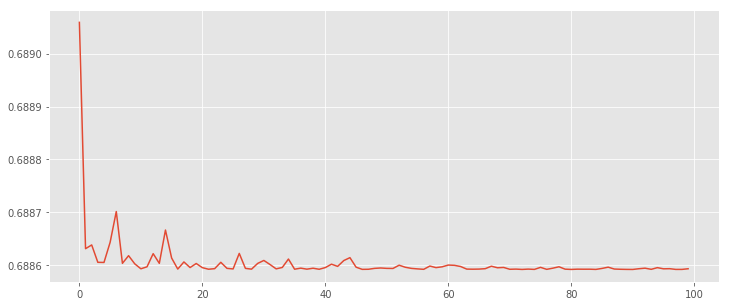

In [213]:
plt.plot(model.losses)

In [116]:
y_hearthstone.shape

(500000L,)

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [186]:
from sklearn.metrics import roc_auc_score

In [235]:
roc_auc_score(y_hearthstone, model.predict(X_hearthstone))

0.64499401847405591

In [ ]:
## Youd Code Here